In [ ]:
%pip install -q --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu  transformers accelerate sentencepiece pillow spacy

In [13]:
from pathlib import Path
import json, re, time, torch
from PIL import Image
import spacy
from transformers import GitProcessor, GitForCausalLM 

RESIZE_TO  = 512           
DEVICE   = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_ID = "microsoft/git-base"
MAX_TOK  = 60
SKIP     = {"product", "picture", "image", "photo", "scene", "sentence"}
nlp      = spacy.load("en_core_web_sm")


In [3]:
def git_caption(img):
    pix = processor(images=img, return_tensors="pt").pixel_values.to(DEVICE)
    with torch.no_grad():
        ids = model.generate(
            pixel_values=pix,
            max_length=80,
            do_sample=True,        # ← enables temperature
            top_p=0.9,
            eos_token_id=processor.tokenizer.eos_token_id,
            pad_token_id=processor.tokenizer.pad_token_id
        )
    return processor.tokenizer.decode(ids[0], skip_special_tokens=True).strip()

def name_desc(path: str | Path):
    img = Image.open(path).convert("RGB")
    if RESIZE_TO:
        img.thumbnail((RESIZE_TO, RESIZE_TO))

    caption = git_caption(img)
    doc = nlp(caption)
    nps = [np for np in doc.noun_chunks
           if np.text.lower().strip(" ,.:;") not in SKIP]

    if nps:
        np = nps[0]
        name = " ".join(t.text for t in np if t.pos_ != "DET")
    else:
        toks = [t for t in doc if t.pos_ == "NOUN"]
        name = toks[0].text if toks else caption.split()[0]

    return {
        "filename": Path(path).name,
        "name": name.capitalize(),
        "description": caption.rstrip(" .") + "."
    }




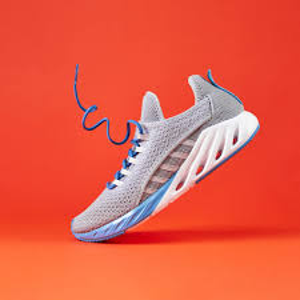

{
  "filename": "images.jpeg",
  "name": "Running shoes",
  "description": "running shoes on a red background available in white, turquoise and orange handmade by me! - - - - unisex87 - - - fotographer - copyright - sold - - 3 - $ 15 in - 01. - -."
}

⏱️  81.29 s on CPU


In [6]:
IMAGE_PATH = "images.jpeg"

tic = time.perf_counter()
result = name_desc(IMAGE_PATH)
toc = time.perf_counter()

display(Image.open(IMAGE_PATH).resize((300, 300)))
print(json.dumps(result, indent=2, ensure_ascii=False))
print(f"\n⏱️  {toc - tic:.2f} s on {DEVICE.upper()}")